In [23]:
import time
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
import numpy as np
from numpy import sort
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm

In [2]:
# 读取差值数据集
dataset_path = '/Users/xiafei/Downloads/itu-dataset/diff_dataset.csv'
testset_path = '/Users/xiafei/Downloads/itu-dataset/diff_testset.csv'

In [3]:
# train
dataset = pd.read_csv(dataset_path)
testset = pd.read_csv(testset_path)

In [4]:
# 删除奇怪的字段
dataset.drop(columns=['Unnamed: 0'], inplace=True)
testset.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
# 删除修复状态
data_drop_index = dataset[dataset['v_type_code'] %2 == 0].index.tolist()
dataset.drop(index=data_drop_index, axis=0, inplace=True)
test_drop_index = testset[testset['v_type_code'] %2 == 0].index.tolist()
testset.drop(index=test_drop_index, axis=0, inplace=True)

print('dataset:')
print(dataset.shape)
print('testset:')
print(testset.shape)

column = dataset.columns

dataset:
(930, 997)
testset:
(840, 997)


# 去掉空值等

In [159]:
# dataset.dropna(axis=1, how='any', inplace=True)
# testset.dropna(axis=1, how='any', inplace=True)
# print('dataset:')
# print(dataset.shape)
# print('testset:')
# print(testset.shape)

# 划分训练测试

In [6]:
X_train = dataset[column[:-1]]
X_test = testset[column[:-1]]
y_train = dataset[column[-1]]
y_test = testset[column[-1]]

X = pd.concat([X_train, X_test], axis=0, ignore_index=True, sort=False)
Y = pd.concat([y_train, y_test], axis=0, ignore_index=True, sort=False)
#     X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(X.shape, Y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1770, 996) (1770,)
(930, 996) (930,)
(840, 996) (840,)


# 正则化  （只有MLP和SVM需要）

In [7]:
ss = StandardScaler()
std_X_train = ss.fit_transform(X_train)
std_X_test = ss.fit_transform(X_test)
# X_train = dataset[column[:-1]].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) if np.max(x) - np.min(x) != 0 else 0)
# X_test = testset[column[:-1]].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) if np.max(x) - np.min(x) != 0 else 0)

In [8]:
#准确率会降到20%
#std_X = ss.fit_transform(X)

# label 做one hot 编码

In [8]:
Y_1 = pd.get_dummies(Y, prefix='type')
Y_1.head()
#Y_1=Y_1.values

,type_1,type_3,type_5,type_7,type_9,type_11
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0


In [9]:
y_train_1 = pd.get_dummies(y_train, prefix='type')
y_test_1 = pd.get_dummies(y_test, prefix='type')
y_train_1.head()

,type_1,type_3,type_5,type_7,type_9,type_11
1,1,0,0,0,0,0
3,1,0,0,0,0,0
5,1,0,0,0,0,0
7,1,0,0,0,0,0
9,1,0,0,0,0,0


In [10]:
# XGBoost
def xgboost(X_train, y_train, X_test, y_test, show=False):
    last_time = time.time()
    xgb = XGBClassifier(n_estimators=100, objective='multi:softprob', num_class=6, random_state=0)
    xgb.fit(X_train, y_train)
    middle_time = time.time()
    y_pred = xgb.predict(X_test)
    current_time = time.time()
    accuracy_score(y_test, y_pred)

    print("训练耗时： {}".format(middle_time - last_time))
    print("测试耗时： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix xgb:')
        print(cm)
        print('classification report xgb:')
        print(classification_report(y_test, y_pred))
        # ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
        plot_confusion_matrix(cm, classes=['1', '3', '5', '7', '9', '11'],
                              normalize=True, title='Normalized confusion matrix')

        plt.show()

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red")
        # color="red" if cm[i, j] > thresh else "black")
    # plt.set_tight_layout(True)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 用xgboost进行特征分析

In [25]:
model = XGBClassifier(importance_type='gain',n_estimators=100)
model.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

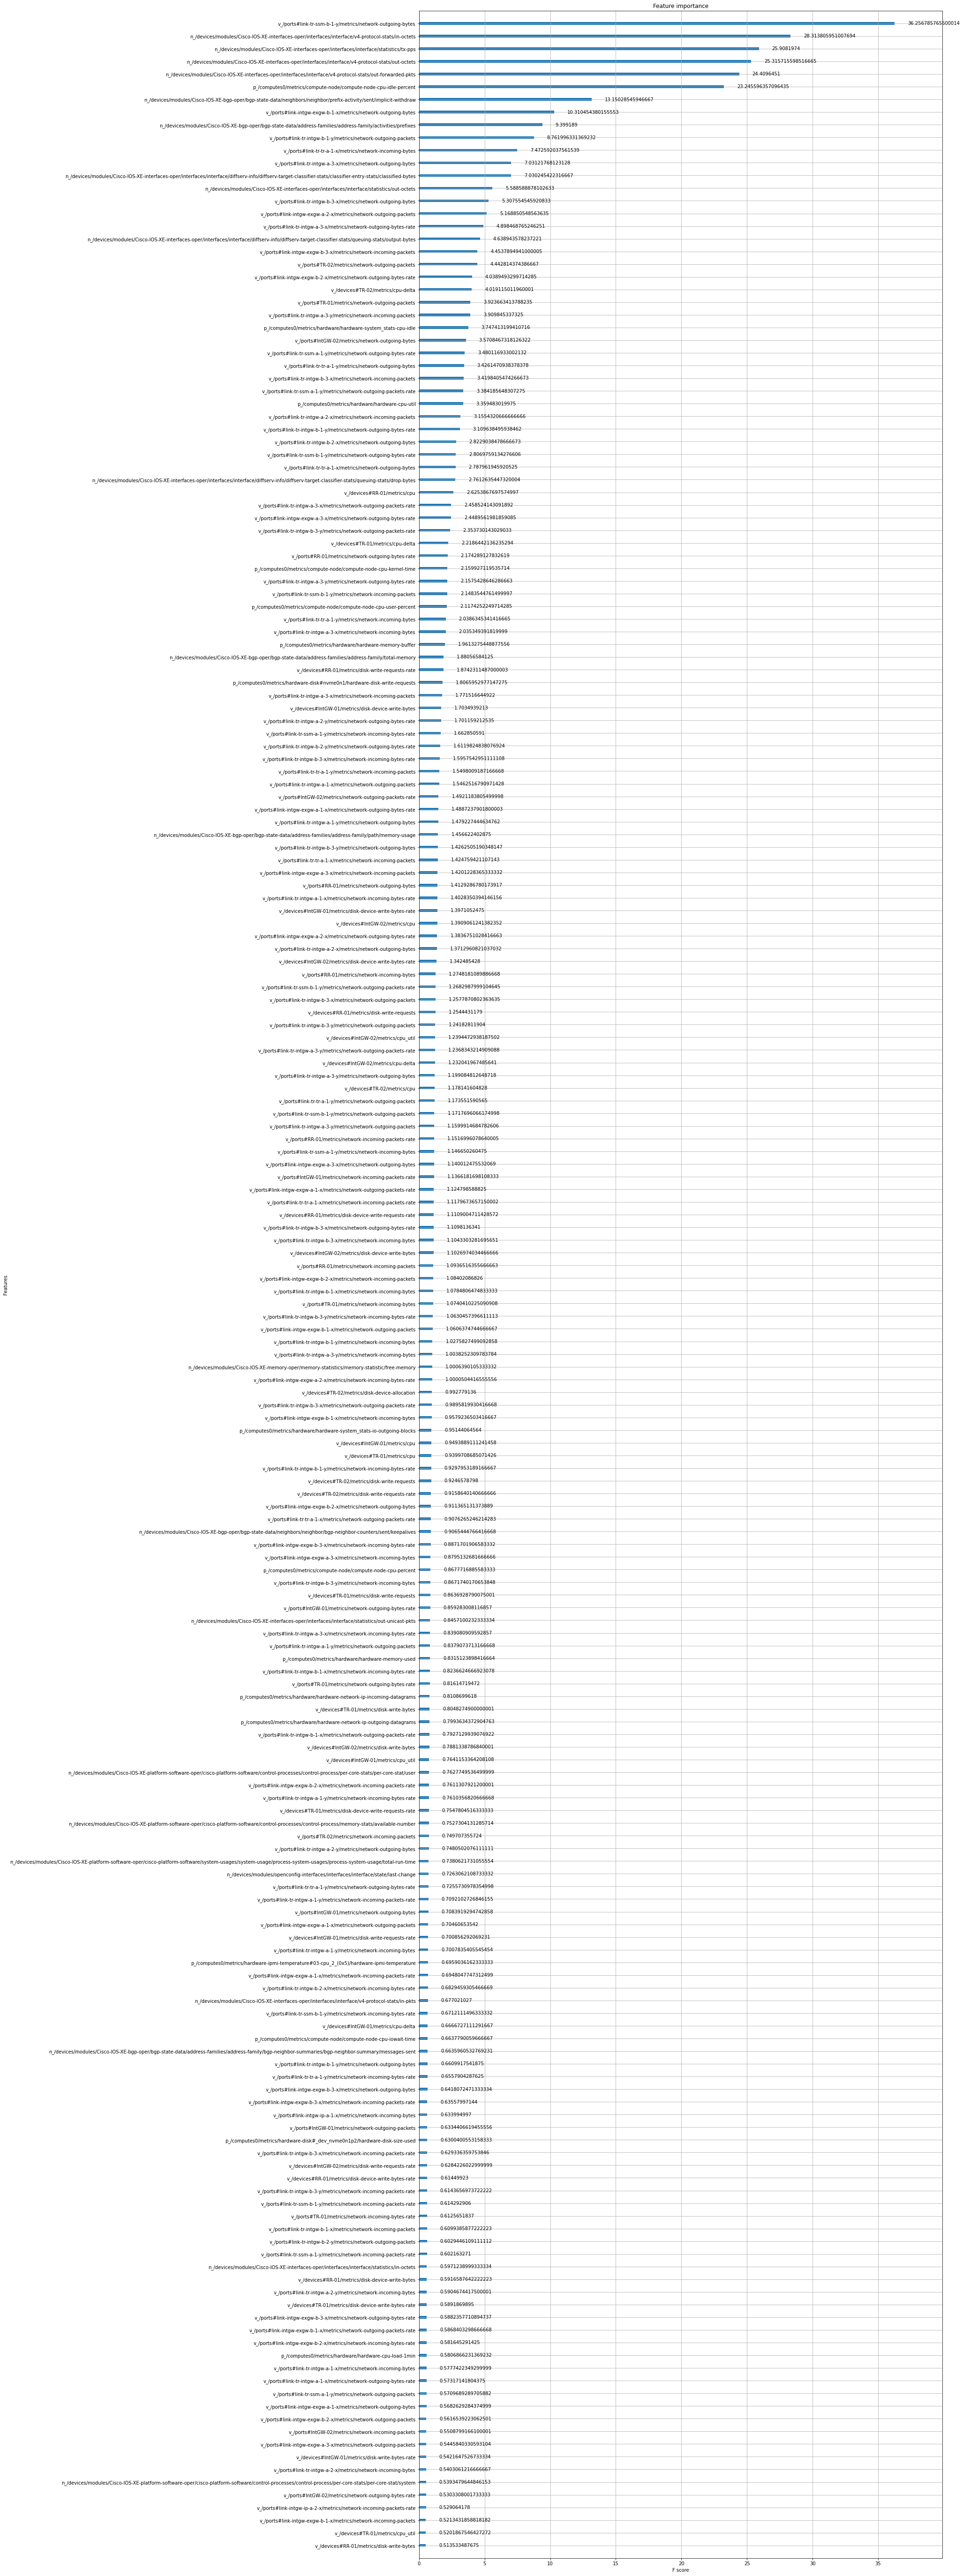

In [26]:
_, ax = plt.subplots(figsize=(20, 100))
plot_importance(model, ax=ax, max_num_features=200, importance_type='gain')
plt.show()

In [27]:
thresholds = sort(model.feature_importances_)[-100:]
print(thresholds)

[0.00204924 0.00206745 0.00208455 0.00208764 0.002098   0.00210006
 0.00211342 0.00212633 0.00214867 0.00215509 0.00216764 0.00217718
 0.00219286 0.00221512 0.00221849 0.00222717 0.00226676 0.00232906
 0.00233812 0.00234306 0.00234756 0.00237141 0.00237773 0.0023976
 0.00240993 0.00253785 0.00259231 0.00261571 0.00262938 0.0026411
 0.00265193 0.00267101 0.00268461 0.00269338 0.0026962  0.00275361
 0.00279634 0.0028143  0.00282071 0.00292305 0.00292976 0.00301663
 0.00304731 0.00314347 0.00321589 0.0032203  0.00334889 0.0034152
 0.00354306 0.00355504 0.00370771 0.00384764 0.00385385 0.0040028
 0.00406127 0.00407864 0.00408314 0.0041103  0.00419414 0.00444951
 0.00462953 0.00464762 0.00496305 0.00521992 0.00527039 0.00530633
 0.00533644 0.00587849 0.00596506 0.0063508  0.00639749 0.0064649
 0.00647682 0.00657884 0.00675036 0.00708414 0.00739121 0.00741733
 0.00759777 0.00763527 0.00839873 0.00841948 0.0087695  0.00926011
 0.00977124 0.01003345 0.01056472 0.01329004 0.01329187 0.01412625


In [28]:
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.4f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy * 100.0))

Thresh=0.0020, n=100, Accuracy: 78.33%
Thresh=0.0021, n=99, Accuracy: 77.02%
Thresh=0.0021, n=98, Accuracy: 77.02%
Thresh=0.0021, n=97, Accuracy: 76.67%
Thresh=0.0021, n=96, Accuracy: 76.79%
Thresh=0.0021, n=95, Accuracy: 77.02%
Thresh=0.0021, n=94, Accuracy: 77.98%
Thresh=0.0021, n=93, Accuracy: 76.07%
Thresh=0.0021, n=92, Accuracy: 78.21%
Thresh=0.0022, n=91, Accuracy: 78.57%
Thresh=0.0022, n=90, Accuracy: 77.50%
Thresh=0.0022, n=89, Accuracy: 76.79%
Thresh=0.0022, n=88, Accuracy: 77.74%
Thresh=0.0022, n=87, Accuracy: 77.14%
Thresh=0.0022, n=86, Accuracy: 78.45%
Thresh=0.0022, n=85, Accuracy: 77.50%
Thresh=0.0023, n=84, Accuracy: 77.26%
Thresh=0.0023, n=83, Accuracy: 78.93%
Thresh=0.0023, n=82, Accuracy: 78.10%
Thresh=0.0023, n=81, Accuracy: 78.57%
Thresh=0.0023, n=80, Accuracy: 77.86%
Thresh=0.0024, n=79, Accuracy: 76.90%
Thresh=0.0024, n=78, Accuracy: 77.50%
Thresh=0.0024, n=77, Accuracy: 77.50%
Thresh=0.0024, n=76, Accuracy: 77.62%
Thresh=0.0025, n=75, Accuracy: 76.31%
Thresh=0.00

# 其他分类方式

In [12]:
def decision_tree(X_train, y_train, X_test, y_test, show=False):
    last_time = time.time()
    dt = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)

    dt.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = dt.predict(X_test)

    current_time = time.time()

    print("Accuracy: %.2f"% accuracy_score(y_test, y_pred))

    print("训练耗时： {}".format(middle_time - last_time))
    print("测试耗时： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix dt:')
        print(cm)
        print('classification report dt:')
        print(classification_report(y_test, y_pred))

        plot_confusion_matrix(cm, classes=['1', '3', '5', '7', '9', '11'],
                              normalize=True, title='Normalized confusion matrix')

        plt.show()

In [13]:
# random forest
def random_forest(X_train, y_train, X_test, y_test, show=False):
    last_time = time.time()
    rf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)

    rf.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = rf.predict(X_test)

    current_time = time.time()

    print("Accuracy: %.2f"% accuracy_score(y_test, y_pred))

    print("训练耗时： {}".format(middle_time - last_time))
    print("测试耗时： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix rf:')
        print(cm)
        print('classification report rf:')
        print(classification_report(y_test, y_pred))

        plot_confusion_matrix(cm, classes=['1', '3', '5', '7', '9', '11'],
                              normalize=True, title='Normalized confusion matrix')

        plt.show()

In [14]:
# MLP
def mlp(std_X_train, y_train, std_X_test, y_test, show=False):
    last_time = time.time()
    mlp = MLPClassifier(solver='sgd', activation='relu', alpha=1e-4, hidden_layer_sizes=(200, 200, 200, 200),
                        random_state=1, max_iter=10000, verbose=0, learning_rate_init=.1)
    mlp.fit(std_X_train, y_train)
    middle_time = time.time()
    y_pred = mlp.predict(std_X_test)
    current_time = time.time()
    print("MLP Accuracy: %.2f"% accuracy_score(y_test, y_pred))
    print("训练耗时： {}".format(middle_time - last_time))
    print("测试耗时： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix MLP:')
        print(cm)
        print('classification report MLP:')
        print(classification_report(y_test, y_pred))
        # '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'
        plot_confusion_matrix(cm, classes=['1', '3', '5', '7', '9', '11', '13'],
                              normalize=True, title='Normalized confusion matrix')

        plt.show()

In [26]:
# SVM
def svm_cross_validation(X, y):
    model = svm.SVC(kernel='rbf', probability=True)
    param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001]}
    grid_search = GridSearchCV(model, param_grid, n_jobs=-1, verbose=1)
    grid_search.fit(X, y)
    best_parameters = grid_search.best_estimator_.get_params()
    for para, val in list(best_parameters.items()):
        print(para, val)
    model = svm.SVC(kernel='rbf', C=best_parameters['C'], gamma=best_parameters['gamma'], probability=True)
    model.fit(X, y)
    return model


def train_svm(std_X_train, y_train, std_X_test, y_test, show=False):
    last_time = time.time()
    model = svm_cross_validation(std_X_train, y_train.ravel())
    middle_time = time.time()
    y_pred = model.predict(std_X_test)
    print("SVM Accuracy: %.2f"% accuracy_score(y_test, y_pred))
    current_time = time.time()
    print("训练耗时： {}".format(middle_time - last_time))
    if show:
        print("测试耗时： {}".format(current_time - middle_time))
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix svm:')
        print(cm)
        print('classification report svm:')
        print(classification_report(y_test, y_pred))
        # '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'
        plot_confusion_matrix(cm, classes=['1', '3', '5', '7', '9', '11', '13'],
                              normalize=True, title='Normalized confusion matrix')

        plt.show()

In [27]:
# one hot label 的DT
decision_tree(X_train, y_train_1, X_test, y_test_1)

Accuracy: 0.62
训练耗时： 0.29790687561035156
测试耗时： 0.012382268905639648


In [51]:
# 普通的 label 的DT
decision_tree(X_train, y_train, X_test, y_test)

Accuracy: 0.62
训练耗时： 0.26656389236450195
测试耗时： 0.007595062255859375


In [52]:
# one hot label 的RF
random_forest(X_train, y_train_1, X_test, y_test_1)

Accuracy: 0.60
训练耗时： 0.8688251972198486
测试耗时： 0.04697394371032715


In [53]:
# 普通label的 RF
random_forest(X_train, y_train, X_test, y_test)

Accuracy: 0.75
训练耗时： 0.7346282005310059
测试耗时： 0.02572178840637207


In [19]:
# 标准化输入和 one hot label 的mlp
mlp(std_X_train, y_train_1, std_X_test, y_test_1)

MLP Accuracy: 0.56
训练耗时： 2.0983428955078125
测试耗时： 0.01763606071472168


In [20]:
# 标准化输入和普通label的mlp
mlp(std_X_train, y_train, std_X_test, y_test)

MLP Accuracy: 0.58
训练耗时： 1.8028221130371094
测试耗时： 0.011056900024414062


In [32]:
# 标准化输入和 one hot label的svm
# 报错 稍后看 DataFrame' object has no attribute 'ravel'
# train_svm(std_X_train, y_train_1, std_X_test, y_test_1)

In [28]:
# 标准化输入和普通label的svm
train_svm(std_X_train, y_train, std_X_test, y_test)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  3.9min finished


C 10
break_ties False
cache_size 200
class_weight None
coef0 0.0
decision_function_shape ovr
degree 3
gamma 0.001
kernel rbf
max_iter -1
probability True
random_state None
shrinking True
tol 0.001
verbose False
SVM Accuracy: 0.56
训练耗时： 247.6468629837036


训练耗时： 9.579672813415527
测试耗时： 0.044622182846069336
confusion matrix xgb:
[[ 60   3   1   0   0   0]
 [  0  50  13   8   1   0]
 [  0   3 143  43   0   0]
 [  0   0  72 106   1   0]
 [  0   0   1   2 153   0]
 [  0   0  29  35   1 115]]
classification report xgb:
              precision    recall  f1-score   support

           1       1.00      0.94      0.97        64
           3       0.89      0.69      0.78        72
           5       0.55      0.76      0.64       189
           7       0.55      0.59      0.57       179
           9       0.98      0.98      0.98       156
          11       1.00      0.64      0.78       180

    accuracy                           0.75       840
   macro avg       0.83      0.77      0.79       840
weighted avg       0.79      0.75      0.75       840

Normalized confusion matrix
[[0.9375     0.046875   0.015625   0.         0.         0.        ]
 [0.         0.69444444 0.18055556 0.11111111 0.01388889 0.        ]
 [0.         0.01587302 0.75

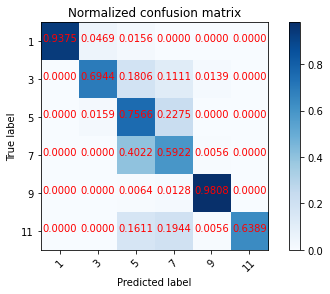

In [29]:
xgboost(X_train, y_train, X_test, y_test,show=True)

# 分割三类文件分别训练

In [55]:
X_train_n = X_train[X_train.columns[:269]]
X_test_n = X_test[X_test.columns[:269]]
X_train_n.head()

,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/paths,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/prefixes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/memory-usage,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/total-entries,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/as,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/bgp-version,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/input-queue,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/messages-received,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/messages-sent,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/output-queue,...,n_/devices/modules/openconfig-interfaces/interfaces/interface/subinterfaces/subinterface/state/counters/last-clear,n_/devices/modules/openconfig-interfaces/interfaces/interface/subinterfaces/subinterface/state/counters/out-broadcast-pkts,n_/devices/modules/openconfig-interfaces/interfaces/interface/subinterfaces/subinterface/state/counters/out-discards,n_/devices/modules/openconfig-interfaces/interfaces/interface/subinterfaces/subinterface/state/counters/out-errors,n_/devices/modules/openconfig-interfaces/interfaces/interface/subinterfaces/subinterface/state/counters/out-multicast-pkts,n_/devices/modules/openconfig-interfaces/interfaces/interface/subinterfaces/subinterface/state/counters/out-octets,n_/devices/modules/openconfig-interfaces/interfaces/interface/subinterfaces/subinterface/state/counters/out-unicast-pkts,n_/devices/modules/openconfig-interfaces/interfaces/interface/subinterfaces/subinterface/state/ifindex,n_/devices/modules/openconfig-interfaces/interfaces/interface/subinterfaces/subinterface/state/last-change,n_nexthop
1,7821.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3790.0,0.0,...,-121000.0,0.0,0.0,0.0,0.0,11099474.0,17706.0,0.0,-121000.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,7.0,0.0,...,91000.0,0.0,0.0,0.0,0.0,11098164.0,17691.0,0.0,91000.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-24.0,-14422.0,0.0,...,25000.0,0.0,0.0,0.0,0.0,13873352.0,22104.0,0.0,25000.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,...,869000.0,0.0,0.0,0.0,0.0,11099771.0,17695.0,0.0,999869000.0,0.0
9,8.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,9.0,0.0,...,30000.0,0.0,0.0,0.0,0.0,11098173.0,17689.0,0.0,30000.0,0.0


In [56]:
X_train_p = X_train[X_train.columns[269:412]]
X_test_p = X_test[X_test.columns[269:412]]
X_train_p.head()

,p_/computes0/cpu_info/topology/cells,p_/computes0/cpu_info/topology/cores,p_/computes0/cpu_info/topology/sockets,p_/computes0/cpu_info/topology/threads,p_/computes0/current_workload,p_/computes0/disk_available_least,p_/computes0/free_disk_gb,p_/computes0/free_ram_mb,p_/computes0/hypervisor_version,p_/computes0/id,...,p_/computes0/metrics/hardware/hardware-network-ip-incoming-datagrams,p_/computes0/metrics/hardware/hardware-network-ip-outgoing-datagrams,p_/computes0/metrics/hardware/hardware-system_stats-cpu-idle,p_/computes0/metrics/hardware/hardware-system_stats-io-incoming-blocks,p_/computes0/metrics/hardware/hardware-system_stats-io-outgoing-blocks,p_/computes0/running_vms,p_/computes0/service/id,p_/computes0/vcpus,p_/computes0/vcpus_used,p_nexthop
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,781293.0,775898.0,2.0,0.0,536744.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,687736.5,866015.0,6.0,0.0,525832.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1155139.0,1149686.0,5.0,0.0,800488.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,775373.5,769948.0,4.0,0.0,524224.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,782965.0,679605.0,7.5,0.0,549792.0,0.0,0.0,0.0,0.0,0.0


In [57]:
X_train_v = X_train[X_train.columns[412:]]
X_test_v = X_test[X_test.columns[412:]]
X_train_v.head()

,v_/devices#IntGW-01/flavor/disk,v_/devices#IntGW-01/flavor/ram,v_/devices#IntGW-01/flavor/vcpus,v_/devices#IntGW-01/image/metrics/image-size,v_/devices#IntGW-01/image/min_disk,v_/devices#IntGW-01/image/min_ram,v_/devices#IntGW-01/image/size,v_/devices#IntGW-01/metrics/compute-instance-booting-time,v_/devices#IntGW-01/metrics/cpu,v_/devices#IntGW-01/metrics/cpu-delta,...,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets-drop,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets-error,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets-drop,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets-error,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets-rate,v_nexthop
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,-3.272000e+10,...,0.0,0.0,-0.000110,3250.0,4.414233,27.0,0.0,0.0,-0.000637,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.306000e+11,9.670000e+09,...,0.0,0.0,0.033176,3302.0,0.849073,29.0,0.0,0.0,-0.000719,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.561100e+11,-3.900000e+08,...,0.0,0.0,0.000054,3932.0,-0.049194,34.0,0.0,0.0,-0.017112,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.077000e+11,-1.446000e+10,...,0.0,0.0,-0.116318,2884.0,-2.326906,26.0,0.0,0.0,-0.000237,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.238100e+11,-1.755000e+10,...,0.0,0.0,-0.116808,0.0,-12.334812,0.0,0.0,0.0,-0.100105,0.0


In [58]:
decision_tree(X_train_n, y_train, X_test_n, y_test)
decision_tree(X_train_p, y_train, X_test_p, y_test)
decision_tree(X_train_v, y_train, X_test_v, y_test)

Accuracy: 0.58
训练耗时： 0.0421600341796875
测试耗时： 0.0038399696350097656
Accuracy: 0.38
训练耗时： 0.0405881404876709
测试耗时： 0.002846956253051758
Accuracy: 0.55
训练耗时： 0.27213501930236816
测试耗时： 0.005850791931152344


In [59]:
random_forest(X_train_n, y_train, X_test_n, y_test)
random_forest(X_train_p, y_train, X_test_p, y_test)
random_forest(X_train_v, y_train, X_test_v, y_test)

Accuracy: 0.64
训练耗时： 0.31224918365478516
测试耗时： 0.02097606658935547
Accuracy: 0.46
训练耗时： 0.2905457019805908
测试耗时： 0.02128005027770996
Accuracy: 0.72
训练耗时： 0.720829963684082
测试耗时： 0.022718191146850586


训练耗时： 13.136831998825073
测试耗时： 0.05598306655883789
confusion matrix xgb:
[[ 50   4   3   4   3   0]
 [  0  37  21  12   1   1]
 [  0   7 131  49   0   2]
 [  0   5  96  75   1   2]
 [  0   0   2   0 154   0]
 [  2   7  38  32   0 101]]
classification report xgb:
              precision    recall  f1-score   support

           1       0.96      0.78      0.86        64
           3       0.62      0.51      0.56        72
           5       0.45      0.69      0.55       189
           7       0.44      0.42      0.43       179
           9       0.97      0.99      0.98       156
          11       0.95      0.56      0.71       180

    accuracy                           0.65       840
   macro avg       0.73      0.66      0.68       840
weighted avg       0.70      0.65      0.66       840

Normalized confusion matrix
[[0.78125    0.0625     0.046875   0.0625     0.046875   0.        ]
 [0.         0.51388889 0.29166667 0.16666667 0.01388889 0.01388889]
 [0.         0.03703704 0.69

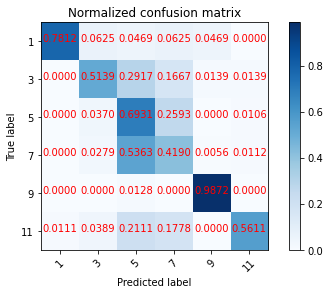

训练耗时： 8.235150814056396
测试耗时： 0.05777406692504883
confusion matrix xgb:
[[ 57   2   2   1   0   2]
 [  1  25  33  11   1   1]
 [  0  17 138  30   4   0]
 [  0  13  87  66  11   2]
 [  0   5 103  35  13   0]
 [  1  11  51  24   4  89]]
classification report xgb:
              precision    recall  f1-score   support

           1       0.97      0.89      0.93        64
           3       0.34      0.35      0.34        72
           5       0.33      0.73      0.46       189
           7       0.40      0.37      0.38       179
           9       0.39      0.08      0.14       156
          11       0.95      0.49      0.65       180

    accuracy                           0.46       840
   macro avg       0.56      0.49      0.48       840
weighted avg       0.54      0.46      0.45       840

Normalized confusion matrix
[[0.890625   0.03125    0.03125    0.015625   0.         0.03125   ]
 [0.01388889 0.34722222 0.45833333 0.15277778 0.01388889 0.01388889]
 [0.         0.08994709 0.730

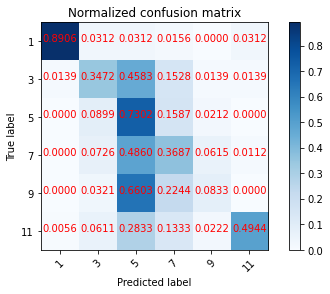

训练耗时： 26.669949054718018
测试耗时： 0.05685591697692871
confusion matrix xgb:
[[ 60   3   1   0   0   0]
 [  0  47  13   6   6   0]
 [  0   2 124  61   2   0]
 [  0   0  51 127   1   0]
 [  0   0   3  11 142   0]
 [  0   3  16  44   1 116]]
classification report xgb:
              precision    recall  f1-score   support

           1       1.00      0.94      0.97        64
           3       0.85      0.65      0.74        72
           5       0.60      0.66      0.62       189
           7       0.51      0.71      0.59       179
           9       0.93      0.91      0.92       156
          11       1.00      0.64      0.78       180

    accuracy                           0.73       840
   macro avg       0.82      0.75      0.77       840
weighted avg       0.78      0.73      0.74       840

Normalized confusion matrix
[[0.9375     0.046875   0.015625   0.         0.         0.        ]
 [0.         0.65277778 0.18055556 0.08333333 0.08333333 0.        ]
 [0.         0.01058201 0.65

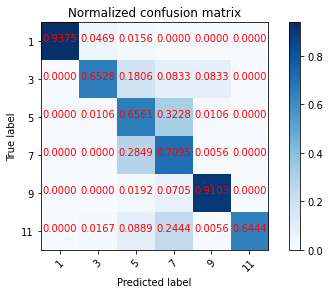

In [60]:
xgboost(X_train_n, y_train, X_test_n, y_test, show=True)
xgboost(X_train_p, y_train, X_test_p, y_test, show=True)
xgboost(X_train_v, y_train, X_test_v, y_test, show=True)